# September 2018 Hurricane Florence case study

This notebook shows how to analyse the output data of the AI-based forecasts of FourCastNetv2.
Please exectue the cells consecutively in order to get a correct result.

- We start analyse the biases in different cyclone metrics. (SLP minimum and location, including the track dependence on initialisation) 
- Then we analyse the Anthropogenic Climate Change (ACC) Attribution on the previous two variables by using the the Pseudo-Global Warming approach (Brogli et al., 2023) simulations.
- We continue by computing centered cyclone composites and computing the storm size as well as the TCWV averaged within a 500 km of the storm center. We compute both the bias (factual - era5) and the ACC fingerprint (factual - counterfactual simulations)

In [1]:
import xarray as xr
import datetime
import numpy as np

# Add the parent directory to the Python path
import sys
sys.path.append('../shared')
import utils
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#START and END of the runs we use for the evaluation of the hurricane Florence
t0_i = datetime.datetime(2018,9,5,0)
t0_f = datetime.datetime(2018,9,15,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [3]:
#load data (modify input directory)
#file structure is organized as follows: '/{root}/{yyyymmddhh}/{var}_{model}_{extension}{yyyymmddhh}.nc'

root='/home/bernatj/Data/ai-forecasts/fcst/'

msl = utils.load_data('msl',init_times, root, extension='', model='fcnv2')
v100 = utils.load_data('v100m', init_times, root, extension='', model='fcnv2')
u100 = utils.load_data('u100m', init_times, root, extension='', model='fcnv2')
tcwv = utils.load_data('tcwv', init_times, root, extension='', model='fcnv2')

In [4]:
#region and time to calculate the trajectories (make it a subregion)
lat_slice=slice(40,18)
lon_slice=slice(275,320)
time_slice=slice('2018-09-05', '2018-09-15')

# Assuming data is your 2D array
msl_area = msl.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
tcwv_area = tcwv.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
latitudes = msl_area.lat
longitudes = msl_area.lon

#same for windspeed
u100_area = u100.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()
v100_area = v100.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

In [5]:
#CALCULATION OF THE TRAJECTORIES
from tropical_cyclone_functions import calculate_trajectory

lat_track_list = []
lon_track_list = []
min_track_list = []

time = msl_area.time
max_len = len(msl_area.time)
init_times=msl_area.init_time

for i,init in enumerate(init_times):
    data = msl_area.sel(init_time=init).data
    lat_track, lon_track, min_track = calculate_trajectory(data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)

    # Pad the lists with np.nan to make them the same length
    lat_track = [np.nan]*i + lat_track + [np.nan]*(max_len - len(lat_track) - i)
    lon_track = [np.nan]*i + lon_track + [np.nan]*(max_len - len(lon_track) - i)
    min_track = [np.nan]*i + min_track + [np.nan]*(max_len - len(min_track) - i)
    
    lat_track_list.append(lat_track)
    lon_track_list.append(lon_track) 
    min_track_list.append(min_track)

# Convert the lists of lists to xarray DataArrays
coords = {'init_time' : init_times, 'time': time}
lat_track_da = xr.DataArray(lat_track_list, coords=coords)
lon_track_da = xr.DataArray(lon_track_list, coords=coords)
min_track_da = xr.DataArray(min_track_list, coords=coords)


break: distance 19.1049731745428, threshold: 100136.0625
break: distance 31.32491021535417, threshold: 99747.5625
break: distance 30.192093335838774, threshold: 99966.5
break: distance 33.05771468205266, threshold: 99630.9375
break: distance 32.685050099395596, threshold: 100368.5625
break: distance 34.77157603560701, threshold: 100236.875
break: distance 34.4746283518764, threshold: 100749.4375
break: distance 34.558826658322765, threshold: 100369.375
break: distance 38.791912816977714, threshold: 100661.75
break: distance 37.03123681434364, threshold: 100540.125
break: distance 37.75248336202534, threshold: 100574.8125
break: distance 37.70361388514369, threshold: 100358.25
break: distance 20.422108118409323, threshold: 100315.5
break: distance 40.749233121618374, threshold: 100279.3125
break: distance 41.35894703688671, threshold: 100441.0625
break: distance 41.6473288459176, threshold: 100242.125
break: distance 39.72798132299199, threshold: 100284.25
break: distance 39.67760703469

In [6]:
#to get ERA5 data we will just convert the other variables to lead time space and pick up lead time 0

#convert variables to lead time coordinate
time_range = msl.time.sel(time=slice('2018-09-05','2018-09-15-18'))
init_time_min = datetime.datetime(2018, 9, 5, 0)
lead_time_range = np.arange(0,10*24,6)

msl_leadtime = utils.from_init_time_to_leadtime(msl_area, init_time_min, lead_time_range, time_range)
tcwv_leadtime = utils.from_init_time_to_leadtime(tcwv_area, init_time_min, lead_time_range, time_range)
u100_leadtime = utils.from_init_time_to_leadtime(u100_area, init_time_min, lead_time_range, time_range)
v100_leadtime = utils.from_init_time_to_leadtime(v100_area, init_time_min, lead_time_range, time_range)

msl_era5 = msl_leadtime[0]
tcwv_era5 = tcwv_leadtime[0]
u100_era5 = u100_leadtime[0]
v100_era5 = v100_leadtime[0]

#and now calculate tracks for ERA5
latitudes = msl_era5.lat.values
longitudes = msl_era5.lon.values
lat_track_era5, lon_track_era5, min_track_era5 = calculate_trajectory(msl_era5.data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)

lat_track_era5_da = xr.DataArray(lat_track_era5, coords={'time' : msl_era5.time})
lon_track_era5_da = xr.DataArray(lon_track_era5, coords={'time' : msl_era5.time})
min_track_era5_da = xr.DataArray(min_track_era5, coords={'time' : msl_era5.time})

## TRAJECTORY PLOT

/home/bernatj/miniconda3/envs/ddp/lib/python3.10/site-packages/shapely/creation.py:119: RuntimeWarning: invalid value encountered in linestrings
  return lib.linestrings(coords, out=out, **kwargs)


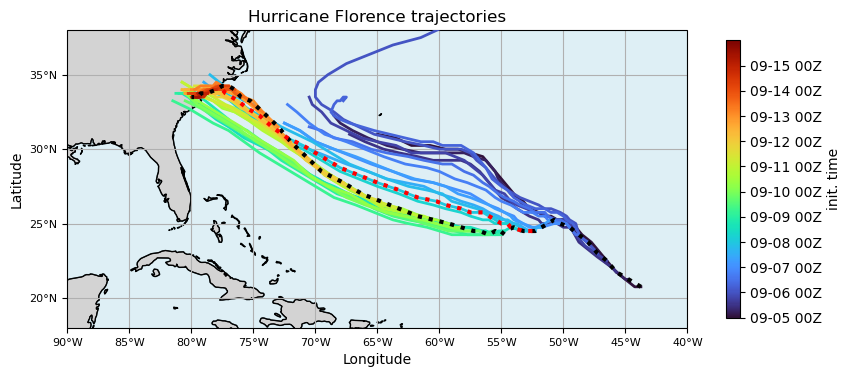

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

start=0

time=min_track_da.time
init_times = time=min_track_da.init_time

# Create subplots with shared y-axis and manually share x-axis
f, ax = plt.subplots(1, 1, figsize=(10,4), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Assuming Natl is your xarray dataset containing latitude and longitude coordinates
# minima_indices is the indices of the minima obtained earlier
latitudes = msl['lat'].values
longitudes = msl['lon'].values

ax.set_aspect(1.2)
ax.coastlines(lw=0.8, color='k')  
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')  # Fill land area
ax.add_feature(cfeature.OCEAN, edgecolor='none', facecolor='lightblue', alpha=0.4)  # Fill ocean area

nLons = np.arange(-180, 180, 5)
nLats = np.arange(20, 41, 5)
ax.set_xticks(nLons, crs=ccrs.PlateCarree())
ax.set_yticks(nLats, crs=ccrs.PlateCarree())
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_ylim([18, 38])
ax.set_xlim([-90, -40])

# format the ticks as e.g 60°W
ax.xaxis.set_major_formatter(LongitudeFormatter())
ax.yaxis.set_major_formatter(LatitudeFormatter())

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Hurricane Florence trajectories')
ax.grid(True)

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('turbo') #plasma

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

for i in range(start,len(init_times)):
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    ax.plot(lon_track_da[i].dropna('time'), lat_track_da[i].dropna('time'), lw=2.0, color=color, transform=ccrs.PlateCarree(), zorder=100)

ax.plot(lon_track_era5, lat_track_era5, lw=3.0, color='k', ls=':', transform=ccrs.PlateCarree(), zorder=101)
ax.plot(lon_track_da.sel(init_time='2018-09-08-00'), lat_track_da.sel(init_time='2018-09-08-00'),\
        lw=3.0, color='r', ls=':', transform=ccrs.PlateCarree(), zorder=101)


# Create a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="init. time", shrink=0.9)
cbar.set_ticks(np.arange(0, len(init_times[start::]),4))

# Format the init_times to show only MM-DD HHUTC
init_time_labels = [time.dt.strftime('%m-%d %HZ').values for time in init_times[start::4]]
cbar.set_ticklabels(init_time_labels)

f.subplots_adjust()
#f.savefig(f'Hurricane_Florence_2018_Tracks_different_inits_factual.pdf',bbox_inches='tight')


## PLOT SHOWING THE EVOLUTION OF MINIMUM SLP 

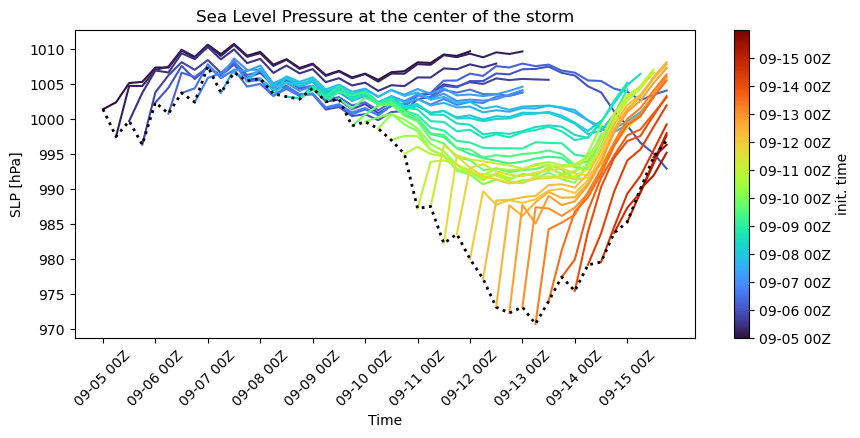

In [8]:
#evolution of pressure at along the track
f, ax = plt.subplots(1, 1, figsize=(10,4))

# Define a colormap that starts from blue and gradually moves towards red
cmap = plt.get_cmap('turbo')
start=0

time=min_track_da.time
init_times = time=min_track_da.init_time

# Normalize initialization times to range from 0 to 1
norm = plt.Normalize(0, len(init_times))

for i in range(start,len(init_times)):
    # Extract latitude and longitude values corresponding to minima_indices
    color = cmap(norm(i))
    plt.plot(min_track_da[i].time, np.array(min_track_da[i])*0.01 , color=color)

plt.plot(msl_era5.time.values[0:len(min_track_era5)], np.array(min_track_era5)*0.01, color='k', lw=2, ls=':')

# Create a colorbar manually
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label="init. time", shrink=1.0)
cbar.set_ticks(np.arange(0, len(init_times[start::]), 4))

# Format the init_times to show only MM-DD HHUTC
init_time_labels = [time.dt.strftime('%m-%d %HZ').values for time in init_times[start::4]]
cbar.set_ticklabels(init_time_labels)

plt.xticks(rotation=45)


# Set the x-axis tick positions to the middle of the raster boxes
ax.set_xticks(min_track_da.time[::4])
ax.set_xticklabels(min_track_da.time[::4].dt.strftime('%m-%d %HZ').values)

# Rotate the tick labels for better readability
plt.xticks(rotation=45,x=-1)

# Add labels and title
ax.set_xlabel('Date')

# Add labels and title
ax.set_xlabel('Time')
ax.set_ylabel('SLP [hPa]')
ax.set_title('Sea Level Pressure at the center of the storm')

# Show the plot
plt.show()

#f.savefig(f'Hurricane_Florence_2018_SLP_Minimum_evolution_different inits.pdf',bbox_inches='tight')

          

## BIAS LEADTIME DEPENDENCE PLOTS

In [9]:
# COnvert to time-leadtime space (selct only dates after Sep 8)
time_range = lat_track_da.time.sel(time=slice('2018-09-08','2018-09-15-18'))
init_time_min = datetime.datetime(2018, 9, 8, 0)
lead_time_range = np.arange(0,10*24,6)
lat_track_leadtime = utils.from_init_time_to_leadtime(lat_track_da, init_time_min, lead_time_range, time_range)
lon_track_leadtime = utils.from_init_time_to_leadtime(lon_track_da, init_time_min, lead_time_range, time_range)
min_track_leadtime = utils.from_init_time_to_leadtime(min_track_da, init_time_min, lead_time_range, time_range)
msl_leadtime = utils.from_init_time_to_leadtime(msl_area, init_time_min, lead_time_range, time_range)

In [10]:
import pandas as pd

#function to plot lead time vs frecast time
def plot_data_leadtime(data, vmin, vmax, cmap='RdBu_r', title='',lt_lines=[5,1],date_lines=['2018-09-14-12'],save=False,\
                      save_name='test'):
    # Create a new figure with desired size
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_facecolor('0.8')

    # Plot the data
    data.plot(ax=ax, cmap=cmap, vmax=vmax, vmin=vmin, extend='both')

    # Add vertical lines at specified dates
    for date in date_lines:
       ax.axvline(x=pd.to_datetime(date), color='k', linestyle='--')

    # Add horizontal lines at specified lead times
    for lt in lt_lines:
        ax.axhline(y=lt*24, color='k', linestyle='--')

    # Set the y-axis tick positions to the middle of the raster boxes
    ax.set_yticks(data[::4].lead_time)
    labels = [(value.values / 24) for value in data[::4].lead_time]
    ax.set_yticklabels(int(label) for label in labels)

    # Set the x-axis tick positions to the middle of the raster boxes
    ax.set_xticks(data.time[::2])
    ax.set_xticklabels(data.time[::2].dt.strftime('%m-%d %HZ').values)

    # Rotate the tick labels for better readability
    plt.xticks(rotation=60)

    # Add labels and title
    ax.set_xlabel('Date')
    ax.set_ylabel('Lead time [days]')
    ax.set_title(title)

    plt.show()

    if save:
        fig.savefig(f'{save_name}.pdf',bbox_inches='tight')
        fig.savefig(f'{save_name}.png')

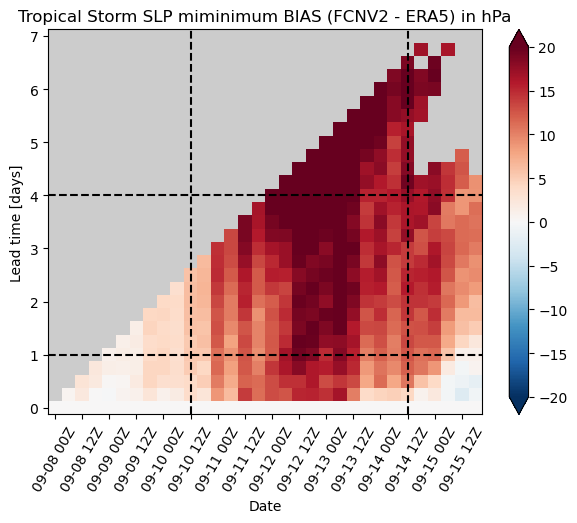

In [11]:
data = ((min_track_leadtime - min_track_era5_da)*0.01).sel(lead_time=slice(0,24*7))
plot_data_leadtime(data,-20,20,title='Tropical Storm SLP miminimum BIAS (FCNV2 - ERA5) in hPa', lt_lines=[1,4], date_lines=['2018-09-10-12','2018-09-14-12'],
                  save=False, save_name='Florence_slp_minimum_bias_leadtime_vs_time')

In [12]:
from tropical_cyclone_functions import haversine

# Assuming dlat and dlon are your xarray DataArrays
dlat = lat_track_leadtime - lat_track_era5_da
dlon = lon_track_leadtime - lon_track_era5_da
lat_track_era5_leadtime = lat_track_leadtime*0 + lon_track_era5_da #just to make it the same dimensions
distance = xr.apply_ufunc(haversine, dlat, dlon, lat_track_leadtime, lat_track_era5_leadtime)


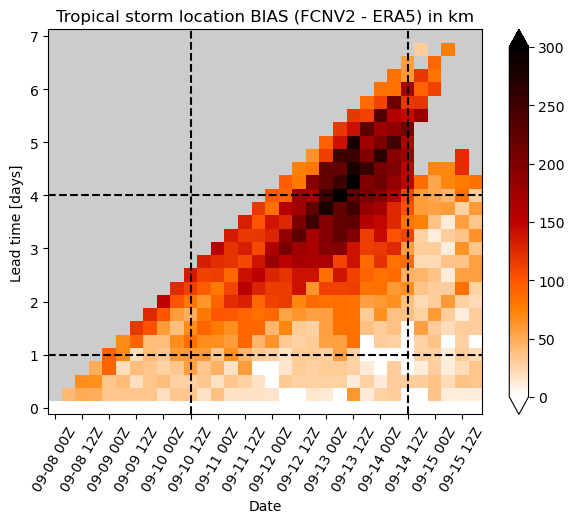

In [13]:
data = distance.sel(lead_time=slice(0,24*7))
plot_data_leadtime(data,0,300,cmap='gist_heat_r', title='Tropical storm location BIAS (FCNV2 - ERA5) in km', lt_lines=[1,4], date_lines=['2018-09-10-12','2018-09-14-12'],\
                  save=False, save_name='Florence_trajectory_bias_leadtime_vs_time')

# AI-based Attribution analysis.

- We need to read temperature from the counterfactual simulations t2m_pgw: PGW from pseudo global warming.

In [14]:
#START and END of the runs we use for the evaluation of the hurricane Florence
t0_i = datetime.datetime(2018,9,8,0)
t0_f = datetime.datetime(2018,9,15,18)
delta_h = 6
# number of forecast steps
num_steps = 4 * 15 # 6h intervals

init_times = []
current_time = t0_i
while current_time <= t0_f:
    init_times.append(current_time)
    current_time += datetime.timedelta(hours=delta_h)

In [15]:
msl_pgw = utils.load_data('msl', init_times, root, extension='PGW_multimodel_', model='fcnv2') 
tcwv_pgw = utils.load_data('tcwv', init_times, root, extension='PGW_multimodel_', model='fcnv2') 
v100_pgw = utils.load_data('v100m', init_times, root, extension='PGW_multimodel_', model='fcnv2') 
u100_pgw = utils.load_data('u100m', init_times, root, extension='PGW_multimodel_', model='fcnv2') 

In [16]:
lat_slice=slice(40,18)
lon_slice=slice(275,320)
time_slice=slice('2018-09-08', '2018-09-15')

# Assuming data is your 2D array
msl_pgw_area = msl_pgw.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
tcwv_pgw_area = tcwv_pgw.sel(lat=lat_slice,lon=lon_slice, time=time_slice)
latitudes = msl_pgw_area.lat
longitudes = msl_pgw_area.lon

#same for windspeed
u100_pgw_area = u100_pgw.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()
v100_pgw_area = v100_pgw.sel(lat=lat_slice,lon=lon_slice, time=time_slice).load()

In [17]:
#calculate trajectories in the counterfactual world
import numpy as np

lat_track_list = []
lon_track_list = []
min_track_list = []

time = msl_pgw_area.time
init_times = msl_pgw_area.init_time
max_len = len(msl_pgw_area.time)

for i,init in enumerate(init_times):
    data = msl_pgw_area.sel(init_time=init).data
    lat_track, lon_track, min_track = calculate_trajectory(data, latitudes, longitudes, threshold_distance=10, threshold_data_value=102500, neighborhood_size=100)

    # Pad the lists with np.nan to make them the same length
    lat_track = [np.nan]*i + lat_track + [np.nan]*(max_len - len(lat_track) - i)
    lon_track = [np.nan]*i + lon_track + [np.nan]*(max_len - len(lon_track) - i)
    min_track = [np.nan]*i + min_track + [np.nan]*(max_len - len(min_track) - i)
    
    lat_track_list.append(lat_track)
    lon_track_list.append(lon_track) 
    min_track_list.append(min_track)

# Convert the lists of lists to xarray DataArrays
coords = {'init_time' : init_times, 'time': time}
lat_track_pgw = xr.DataArray(lat_track_list, coords=coords)
lon_track_pgw = xr.DataArray(lon_track_list, coords=coords)
min_track_pgw = xr.DataArray(min_track_list, coords=coords)

break: distance 35.94614026568082, threshold: 100358.25
break: distance 19.97029043354152, threshold: 100315.5
break: distance 19.981241202688086, threshold: 100279.3125
break: distance 39.56718969044933, threshold: 100441.0625
break: distance 40.673240588868744, threshold: 100242.125
break: distance 39.421599409460796, threshold: 100284.25
break: distance 39.84736503208211, threshold: 99897.5625
break: distance 40.48533685175412, threshold: 99957.8125
break: distance 40.16372741666291, threshold: 99859.875
break: distance 39.528470752104745, threshold: 99693.375


In [18]:
#convert variables into time/lead time space
time_range = lat_track_da.time.sel(time=slice('2018-09-08','2018-09-15-18'))
init_time_min = datetime.datetime(2018, 9, 8, 0)
lead_time_range = np.arange(0,10*24,6)
lat_track_pgw_leadtime = utils.from_init_time_to_leadtime(lat_track_pgw, init_time_min, lead_time_range, time_range)
lon_track_pgw_leadtime = utils.from_init_time_to_leadtime(lon_track_pgw, init_time_min, lead_time_range, time_range)
min_track_pgw_leadtime = utils.from_init_time_to_leadtime(min_track_pgw, init_time_min, lead_time_range, time_range)
msl_pgw_leadtime = utils.from_init_time_to_leadtime(msl_pgw_area, init_time_min, lead_time_range, time_range)

## Impact of ACC on minimum SLP and storm location

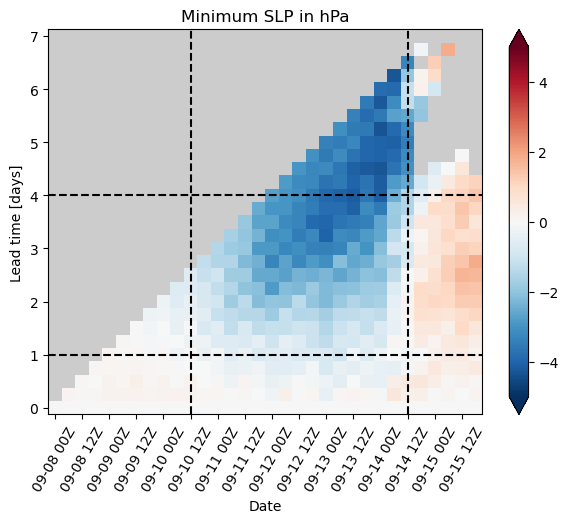

In [19]:
data=((min_track_leadtime - min_track_pgw_leadtime)*0.01).sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,-5,5,title='Minimum SLP in hPa', lt_lines=[1,4],\
                   date_lines=['2018-09-10-12','2018-09-14-12'],\
                    save=False, save_name='PGW_Florence_minimumSLP_leadtime_vs_time')


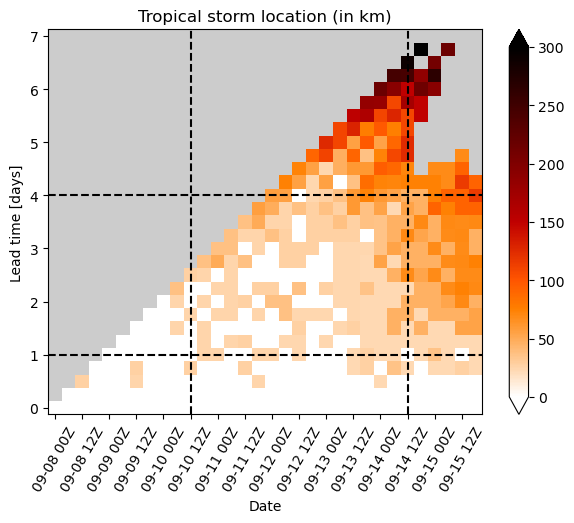

In [20]:
# Assuming dlat and dlon are your xarray DataArrays
dlat = lat_track_leadtime - lat_track_pgw_leadtime
dlon = lon_track_leadtime - lon_track_pgw_leadtime
distance_pgw = xr.apply_ufunc(haversine, dlat, dlon, lat_track_leadtime, lat_track_pgw_leadtime)
data=distance_pgw.sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,0,300, cmap='gist_heat_r',title='Tropical storm location (in km)',lt_lines=[1,4],\
                   date_lines=['2018-09-10-12','2018-09-14-12'],\
                  save=False, save_name='PGW_Florence_distance_leadtime_vs_time')

# Storm centered composites and Storm Size analysis

In [21]:
#select an area to make the computation less expensive and convert to time/leadtime coordinates

lat_slice=slice(45,10)
lon_slice=slice(240,320)

msl_leadtime = utils.from_init_time_to_leadtime(msl.sel(lat=lat_slice, lon=lon_slice)\
                                          , init_time_min, lead_time_range, time_range).load()
tcwv_leadtime = utils.from_init_time_to_leadtime(tcwv.sel(lat=lat_slice, lon=lon_slice)\
                                           , init_time_min, lead_time_range, time_range).load()
u100_leadtime = utils.from_init_time_to_leadtime(u100.sel(lat=lat_slice, lon=lon_slice)\
                                           , init_time_min, lead_time_range, time_range).load()
v100_leadtime = utils.from_init_time_to_leadtime(v100.sel(lat=lat_slice, lon=lon_slice)\
                                           , init_time_min, lead_time_range, time_range).load()

msl_pgw_leadtime = utils.from_init_time_to_leadtime(msl_pgw.sel(lat=lat_slice, lon=lon_slice)\
                                              , init_time_min, lead_time_range, time_range).load()
tcwv_pgw_leadtime = utils.from_init_time_to_leadtime(tcwv_pgw.sel(lat=lat_slice, lon=lon_slice)\
                                               , init_time_min, lead_time_range, time_range).load()
u100_pgw_leadtime = utils.from_init_time_to_leadtime(u100_pgw.sel(lat=lat_slice, lon=lon_slice)\
                                               , init_time_min, lead_time_range, time_range).load()
v100_pgw_leadtime = utils.from_init_time_to_leadtime(v100_pgw.sel(lat=lat_slice, lon=lon_slice)\
                                               , init_time_min, lead_time_range, time_range).load()

In [22]:
# Create a new DataArray for the variable with extra dimensions

#We create a new data array to store the centered snapshots of the hurricane
res_deg =0.25
nlat = 30 #number of lat points from the center of the storm
nlon = 30 #number of lon points the center of the storm
rel_lat = np.arange(-nlat*res_deg,(nlat+1)*res_deg, res_deg)
rel_lon = np.arange(-nlon*res_deg,(nlon+1)*res_deg, res_deg)

dims = ["lead_time", "time", "rel_lat", "rel_lon"] 
coords = {dim: msl_leadtime.coords[dim] for dim in msl_leadtime.dims[0:2]}
coords.update({'rel_lat' : rel_lat ,'rel_lon' : rel_lon})

msl_storm = xr.DataArray(dims=dims, coords=coords)
tcwv_storm = msl_storm.copy()
wsp_storm = msl_storm.copy()
radius_storm = msl_storm.copy() 

msl_pgw_storm = msl_storm.copy()
tcwv_pgw_storm = msl_storm.copy()
wsp_pgw_storm = msl_pgw_storm.copy()
radius_pgw_storm = msl_pgw_storm.copy() 

- In the cell below we parallelize the calculation of the tropical cyclone centered snapshots of several variables of interest. This significant speeds up the computation. Please adapt the ```max_workers``` to your system´s capabilities

In [23]:
import concurrent.futures
from tropical_cyclone_functions import compute_storm_data

leadtimes = np.arange(0, 7*24, 6)
# Define a wrapper function for the computation
def process_time(lt, t, msl_func, tcwv_func, u100_func, v100_func, lat_track_func, lon_track_func):
    try:
        radius_result, msl_result, tcwv_result, wsp_result = compute_storm_data(
            msl_func,
            tcwv_func,
            u100_func,
            v100_func,
            lat_track_func,
            lon_track_func,
            msl_func.lat, msl_func.lon,
            rel_lat, rel_lon)
        return lt, t, radius_result, msl_result, tcwv_result, wsp_result
    except Exception as e:
        return lt, t, None, None, None, None
    
# Set the maximum number of parallel jobs
max_workers = 150  # Adjust this number based on your system's capabilities
# Use ProcessPoolExecutor for parallel processing
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for lt in leadtimes:
        for t in msl_leadtime.time:
            futures.append(executor.submit(process_time, lt, t, msl_leadtime.sel(lead_time=lt, time=t), tcwv_leadtime.sel(lead_time=lt, time=t),\
                                             u100_leadtime.sel(lead_time=lt, time=t), v100_leadtime.sel(lead_time=lt, time=t),\
                                             lat_track_leadtime.sel(lead_time=lt, time=t), lon_track_leadtime.sel(lead_time=lt, time=t)))
    # Process results as they 
    for future in concurrent.futures.as_completed(futures):
        try:
            lt, t, radius_result, msl_result, tcwv_result, wsp_result = future.result()
            if radius_result is not None and msl_result is not None and wsp_result is not None:
                radius_storm.loc[{'lead_time': lt, 'time': t}] = radius_result
                msl_storm.loc[{'lead_time': lt, 'time': t}] = msl_result
                tcwv_storm.loc[{'lead_time': lt, 'time': t}] = tcwv_result
                wsp_storm.loc[{'lead_time': lt, 'time': t}] = wsp_result
            else:
                print(f"Computation not possible for lead_time {lt} and time {t.values}")
        except Exception as e:
            print(f"An error occurred during parallel processing: {e}")

#same for counterfactual simulations
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
    futures = []
    for lt in leadtimes:
        for t in msl_leadtime.time:
            futures.append(executor.submit(process_time, lt, t, msl_pgw_leadtime.sel(lead_time=lt, time=t), tcwv_pgw_leadtime.sel(lead_time=lt, time=t),\
                                             u100_pgw_leadtime.sel(lead_time=lt, time=t), v100_pgw_leadtime.sel(lead_time=lt, time=t),\
                                             lat_track_pgw_leadtime.sel(lead_time=lt, time=t), lon_track_pgw_leadtime.sel(lead_time=lt, time=t)))
    # Process results as they 
    for future in concurrent.futures.as_completed(futures):
        try:
            lt, t, radius_result, msl_result, tcwv_result, wsp_result = future.result()
            if radius_result is not None and msl_result is not None and wsp_result is not None:
                radius_pgw_storm.loc[{'lead_time': lt, 'time': t}] = radius_result
                msl_pgw_storm.loc[{'lead_time': lt, 'time': t}] = msl_result
                tcwv_pgw_storm.loc[{'lead_time': lt, 'time': t}] = tcwv_result
                wsp_pgw_storm.loc[{'lead_time': lt, 'time': t}] = wsp_result
            else:
                print(f"Computation not possible for lead_time {lt} and time {t.values}")
        except Exception as e:
            print(f"An error occurred during parallel processing: {e}")




Computation not possible for lead_time 6 and time 2018-09-08T00:00:00.000000000
Computation not possible for lead_time 12 and time 2018-09-08T06:00:00.000000000
Computation not possible for lead_time 12 and time 2018-09-08T00:00:00.000000000
Computation not possible for lead_time 18 and time 2018-09-08T00:00:00.000000000
Computation not possible for lead_time 18 and time 2018-09-08T12:00:00.000000000
Computation not possible for lead_time 18 and time 2018-09-08T06:00:00.000000000
Computation not possible for lead_time 24 and time 2018-09-08T00:00:00.000000000
Computation not possible for lead_time 24 and time 2018-09-08T12:00:00.000000000
Computation not possible for lead_time 24 and time 2018-09-08T06:00:00.000000000
Computation not possible for lead_time 24 and time 2018-09-08T18:00:00.000000000
Computation not possible for lead_time 30 and time 2018-09-08T06:00:00.000000000
Computation not possible for lead_time 30 and time 2018-09-08T12:00:00.000000000
Computation not possible for 

## Calculate the STORM SIZE using a 10 m/s threshold

In [24]:
from tropical_cyclone_functions import calculate_storm_size_int, transform_to_radius

target_windspeed = 10 # Example target wind speed

msl_storm_radius, wsp_storm_radius, max_wsp_storm_radius =  \
    transform_to_radius(msl_storm, wsp_storm, radius_storm, incr_radius=np.arange(0,700,25))
msl_pgw_storm_radius, wsp_pgw_storm_radius,  max_wsp_pgw_storm_radius = \
     transform_to_radius(msl_pgw_storm, wsp_pgw_storm, radius_pgw_storm, incr_radius=np.arange(0,700,25))

storm_size = xr.apply_ufunc(
    calculate_storm_size_int,
    wsp_storm_radius,
    wsp_storm_radius.radius,
    kwargs={'target_windspeed': target_windspeed},
    input_core_dims=[['radius'], ['radius']],
    output_core_dims=[[]],
    vectorize=True
)
storm_size = storm_size.where(storm_size != 0., np.nan)   

storm_size_pgw = xr.apply_ufunc(
    calculate_storm_size_int,
    wsp_pgw_storm_radius,
    wsp_pgw_storm_radius.radius,
    kwargs={'target_windspeed': target_windspeed},
    input_core_dims=[['radius'], ['radius']],
    output_core_dims=[[]],
    vectorize=True
)
storm_size_pgw = storm_size_pgw.where(storm_size_pgw != 0., np.nan)  

Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cannot reshape array of size 0 into shape (0,newaxis)
Interpolation error: cann

## Storm size BIAS and ACC fingerprint

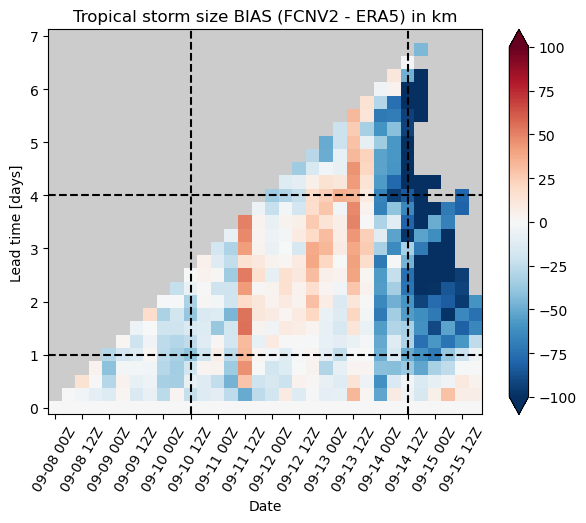

In [25]:
data = (storm_size - storm_size[0]).sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,-100,100, title='Tropical storm size BIAS (FCNV2 - ERA5) in km',lt_lines=[1,4], date_lines=['2018-09-10-12','2018-09-14-12'],\
                  save=False, save_name='Florence_stormsize_bias_leadtime_vs_time')

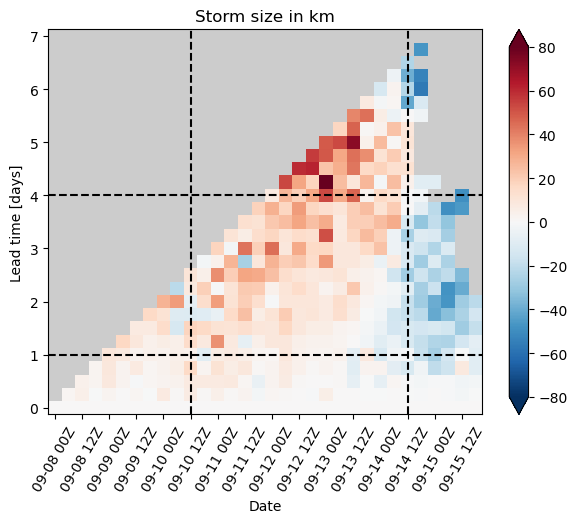

In [26]:
data = (storm_size - storm_size_pgw).sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,-80,80, title='Storm size in km',lt_lines=[1,4],\
                   date_lines=['2018-09-10-12','2018-09-14-12'],\
                  save=False, save_name='PGW_Florence_stormsize_leadtime_vs_time')

## Precipitable water (total column water vapour TCWV) averaged for a radius of 500 km arroun the storm center

In [27]:
#TCWV averaged for a radius < 500 km

bool = (radius_storm <= 500)
tcwv_center = (tcwv_storm * bool)
tcwv_center = tcwv_center.where(tcwv_center != 0, np.nan).mean(['rel_lat','rel_lon'])

bool = (radius_pgw_storm <= 500)
tcwv_center_pgw = (tcwv_pgw_storm * bool)
tcwv_center_pgw = tcwv_center_pgw.where(tcwv_center_pgw != 0, np.nan).mean(['rel_lat','rel_lon'])

-  BIAS (MODEL - ERA5)

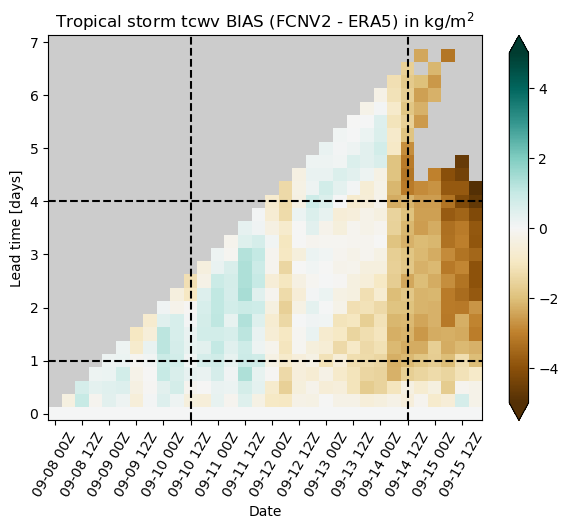

In [28]:
#integrated water vapour
bool = (radius_storm <= 500)
tcwv_center = (tcwv_storm * bool)
tcwv_center = tcwv_center.where(tcwv_center != 0, np.nan).mean(['rel_lat','rel_lon'])
bool = (radius_pgw_storm <= 500)
tcwv_center_pgw = (tcwv_pgw_storm * bool)
tcwv_center_pgw = tcwv_center_pgw.where(tcwv_center_pgw != 0, np.nan).mean(['rel_lat','rel_lon'])
plt.rc('text', usetex=False)
data = (tcwv_center-  tcwv_center[0]).sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,-5,5, title=r'Tropical storm tcwv BIAS (FCNV2 - ERA5) in kg/m$^2$',lt_lines=[1,4],\
                       date_lines=['2018-09-10-12','2018-09-14-12'],cmap='BrBG',\
                       save=False, save_name='Florence_tcwv_radius500km_bias_leadtime_vs_time')

-  ACC fingerprint (factual - counterfactual)

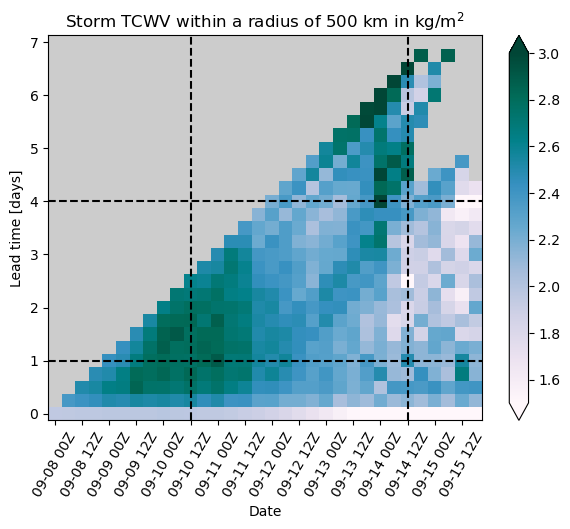

In [29]:
data = (tcwv_center - tcwv_center_pgw).sel(lead_time=slice(0,7*24))
plot_data_leadtime(data,1.5,3, title='Storm TCWV within a radius of 500 km in kg/m$^2$',\
                   cmap='PuBuGn', lt_lines=[1,4], date_lines=['2018-09-10-12','2018-09-14-12'],\
                  save=False, save_name='PGW_Florence_tcwv_radius500km_leadtime_vs_time')

# Composites arround the storm 

- We average from lead time 1 day to 4 days. We use all available inits within this time to compute statistically signifcance between the two samples (factual and counterfactual)

In [30]:
from scipy import stats

#prepare the data

t_i = 16 # first time we have at least until lead time of 4 days
int=4 # integer that represent every how many timesteps we want to do teh composite (in this case once a day)

data_wsp=(wsp_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time') -\
        wsp_pgw_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time'))[t_i::int]
data_wsp_c=wsp_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time')[t_i::int]
#significance:
sample1= wsp_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
sample2= wsp_pgw_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
_, p_value_wsp = stats.ttest_ind(sample1, sample2, axis=0)

data_msl=(msl_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time') -\
        msl_pgw_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time'))[t_i::int]
data_msl_c=msl_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time')[t_i::int]
#significance:
sample1= msl_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
sample2= msl_pgw_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
_, p_value_msl = stats.ttest_ind(sample1, sample2, axis=0)

data_tcwv=(tcwv_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time') -\
        tcwv_pgw_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time'))[t_i::int]
data_tcwv_c=tcwv_storm.sel(lead_time=slice(1*24,4*24)).mean('lead_time')[t_i::int]
#significance:
sample1= tcwv_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
sample2= tcwv_pgw_storm.sel(lead_time=slice(1*24,4*24))[:,t_i::int].values
_, p_value_tcwv = stats.ttest_ind(sample1, sample2, axis=0)

/tmp/ipykernel_3581851/4086386257.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_3581851/4086386257.py:39: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for collection in plot13.collections:
/tmp/ipykernel_3581851/4086386257.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = mpl.cm.get_cmap(cmap_name, 256)
/tmp/ipykernel_3581851/4086386257.py:55: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed two minor releases later.
  for c

Text(0.5, 0.98, 'Climate Change impact (factual - counterfactual) on simulated hurricane Florence')

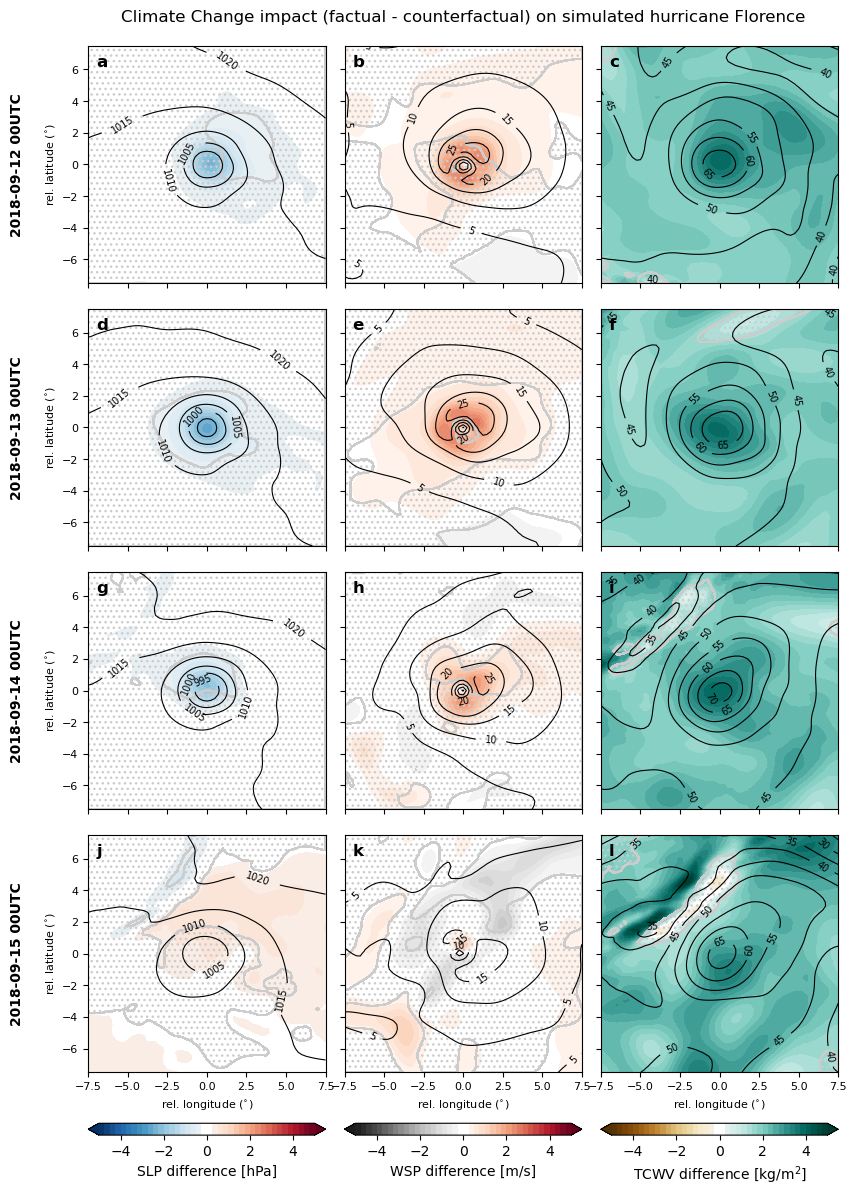

In [31]:
import matplotlib as mpl


# Create subplots with shared y-axis and manually share x-axis
fig, axes = plt.subplots(4, 3, sharey=True, sharex=True, figsize=(7.5,15))

# Create color map
cmap_name='RdBu_r'
colors = mpl.cm.get_cmap(cmap_name, 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

lat, lon = data_wsp.rel_lat, data_wsp.rel_lon

alphabet_list = [chr(i) for i in range(ord('a'), ord('a') + 15)]

for i,ax in enumerate(axes.flatten()):
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_facecolor('0.9')
    ax.set_aspect(1)
    ax.text(-7, 6.2, alphabet_list[i], fontsize=12, fontweight='bold')
    if i%3==0:
        ax.set_ylabel('rel. latitude ($^{\circ}$)', fontsize=8)
    if i>=3*3:
        ax.set_xlabel('rel. longitude ($^{\circ}$)', fontsize=8)

for j in range(0,4):
    side_text= data_wsp.time.dt.strftime('%Y-%m-%d %HUTC').values[j]
    axes[j,0].text(-12, 0, side_text, rotation=90,verticalalignment='center', horizontalalignment='center', fontsize=10, fontweight='bold')

# Loop through subplots
for i, ax in enumerate(axes[:,0]): 
    plot11 = ax.contour(lat, lon, data_msl_c[i]*0.01, levels=np.arange(970,1036,5), colors='k', linewidths=0.8)
    plt.clabel(plot11, fontsize=7, fmt='%1.0f')
    plot12 = ax.contourf(lat, lon, data_msl[i]*0.01, cmap=newcmap, levels=np.arange(-5,5.1,0.25), extend='both', alpha=1.0)
    plot13 = ax.contourf(lat, lon, p_value_msl[i], colors='none', levels=[0.05,1], hatches=['...',''])
    for collection in plot13.collections:
        collection.set_edgecolor('0.8')  # Set the hatch color to red

# Create color map
cmap_name='RdGy_r'
colors = mpl.cm.get_cmap(cmap_name, 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

for i, ax in enumerate(axes[:,1]):
    plot21 = ax.contour(lat, lon, data_wsp_c[i], levels=np.arange(0,30,5), colors='k', linewidths=0.8)
    plt.clabel(plot21, fontsize=7, fmt='%1.0f')
    plot22 = ax.contourf(lat, lon, data_wsp[i], cmap=newcmap, levels=np.arange(-5,5.1,0.25), extend='both', alpha=1.0)
    plot23 = ax.contourf(lat, lon, p_value_wsp[i], colors='none', levels=[0.05,1], hatches=['...',''])
    for collection in plot23.collections:
        collection.set_edgecolor('0.8')  # Set the hatch color to red

# Create color map
cmap_name='BrBG'
colors = mpl.cm.get_cmap(cmap_name, 256)
newcolors = colors(np.linspace(0, 1, 256))
white = np.array([1, 1, 1, 1])
newcolors[120:137, :] = white
newcmap = mpl.colors.ListedColormap(newcolors)

for i, ax in enumerate(axes[:,2]):
    plot31 = ax.contour(lat, lon, data_tcwv_c[i], levels=np.arange(20,80,5), colors='k', linewidths=0.8)
    plt.clabel(plot31, fontsize=7, fmt='%1.0f')
    plot32 = ax.contourf(lat, lon, data_tcwv[i], cmap=newcmap, levels=np.arange(-5,5.1,0.25), extend='both', alpha=1.0)
    plot33 = ax.contourf(lat, lon, p_value_tcwv[i], colors='none', levels=[0.05,1], hatches=['...',''])
    for collection in plot33.collections:
        collection.set_edgecolor('0.8')  # Set the hatch color to red

# Adjust subplot layout
fig.subplots_adjust(hspace=0.08, wspace=0.08, left=0.0, right=1.0, bottom=0.11, top=0.96)


# Add common colorbar
cbar1 = plt.colorbar(plot12, ax=axes[:,0], label='SLP difference [hPa]', orientation='horizontal', shrink=1.0, pad=0.04, aspect=20)
cbar2 = plt.colorbar(plot22, ax=axes[:,1], label='WSP difference [m/s]', orientation='horizontal', shrink=1.0, pad=0.04, aspect=20)
cbar3 = plt.colorbar(plot32, ax=axes[:,2], label='TCWV difference [kg/m$^2$]', orientation='horizontal', shrink=1.0, pad=0.04, aspect=20)

# Custom ticks and labels
ticks = np.arange(-4,6,2)
cbar1.set_ticks(ticks)
cbar2.set_ticks(ticks)
cbar3.set_ticks(ticks)

# Add main title
plt.suptitle('Climate Change impact (factual - counterfactual) on simulated hurricane Florence', fontsize=12)

#plt.savefig('Fig_pgw_sensitivity_slp_wsp_tcwv_avg_leadtimes_1-4days.pdf', bbox_inches='tight')